# 2. SageMaker BatchTransform Job

In [1]:
install_needed = True
# install_needed = False

In [2]:
%%bash
#!/bin/bash

DAEMON_PATH="/etc/docker"
MEMORY_SIZE=10G

FLAG=$(cat $DAEMON_PATH/daemon.json | jq 'has("data-root")')
# echo $FLAG

if [ "$FLAG" == true ]; then
    echo "Already revised"
else
    echo "Add data-root and default-shm-size=$MEMORY_SIZE"
    sudo cp $DAEMON_PATH/daemon.json $DAEMON_PATH/daemon.json.bak
    sudo cat $DAEMON_PATH/daemon.json.bak | jq '. += {"data-root":"/home/ec2-user/SageMaker/.container/docker","default-shm-size":"'$MEMORY_SIZE'"}' | sudo tee $DAEMON_PATH/daemon.json > /dev/null
    sudo service docker restart
    echo "Docker Restart"
fi

sudo curl -L "https://github.com/docker/compose/releases/download/v2.7.0/docker-compose-$(uname -s)-$(uname -m)" -o /usr/local/bin/docker-compose
sudo chmod +x /usr/local/bin/docker-compose

Add data-root and default-shm-size=10G


Redirecting to /bin/systemctl restart docker.service


Docker Restart


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 24.5M  100 24.5M    0     0  93.6M      0 --:--:-- --:--:-- --:--:-- 93.6M


In [2]:
import sys
import IPython

if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install --upgrade pip --quiet
    !{sys.executable} -m pip install -U sagemaker --quiet
    IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel


# Start

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sagemaker
import huggingface_hub
from pathlib import Path
from time import strftime

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
)
import torch


source_dir = f"{Path.cwd()}/src"
os.makedirs(source_dir, exist_ok=True)

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "240929-deploy-owl-vit"

role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
os.environ['HF_DATASETS_CACHE'] = '/home/ec2-user/SageMaker/.cache'
os.environ['HF_CACHE_HOME'] = '/home/ec2-user/SageMaker/.cache'
os.environ['HUGGINGFACE_HUB_CACHE'] = '/home/ec2-user/SageMaker/.cache'
# os.environ['TRANSFORMERS_HOME'] = '/home/ec2-user/SageMaker/.cache'
# os.environ['HF_HOME'] = '/home/ec2-user/SageMaker/.cache'

In [4]:
test_model_id = 'google/owlvit-base-patch32'

<br>

## [**Step 1**] Storing model artifacts and serving/scoring logic
---

### 1. Downloading model

In [5]:
registered_model = test_model_id.split("/")[-1].lower().replace(".", "-")
print(f"registered_model : {registered_model}")
os.makedirs(registered_model, exist_ok=True)

huggingface_hub.snapshot_download(
    repo_id=test_model_id,
    revision="main",
    local_dir=registered_model
)

registered_model : owlvit-base-patch32


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

'/home/ec2-user/SageMaker/2024/inference-code/owl-vit-on-sagemaker/owlvit-base-patch32'

In [6]:
local_model_weight = test_model_id.split("/")[-1].lower().replace(".", "-")
local_model_weight

'owlvit-base-patch32'

In [7]:
s3_model_weight_path = sagemaker_session.upload_data(path=f'./{local_model_weight}', bucket=bucket, key_prefix=f"{prefix}/{local_model_weight}")
print('Model weight spec (in this case, just an S3 path): {}'.format(s3_model_weight_path))

Model weight spec (in this case, just an S3 path): s3://sagemaker-us-west-2-322537213286/240929-deploy-owl-vit/owlvit-base-patch32


In [8]:
s3_input_data_path = sagemaker_session.upload_data(path=f'./ecommerce-products', bucket=bucket, key_prefix=f"{prefix}/ecommerce-products")
print('input spec (in this case, just an S3 path): {}'.format(s3_input_data_path))

input spec (in this case, just an S3 path): s3://sagemaker-us-west-2-322537213286/240929-deploy-owl-vit/ecommerce-products


아래 코드 셀은 src 디렉토리에 SageMaker 추론 스크립트를 저장합니다.

#### Option 1.
- `model_fn(model_dir)`: S3의 `model_dir`에 저장된 모델 아티팩트를 로드합니다.
- `input_fn(request_body, content_type)`: 입력 데이터를 전처리합니다. `content_type`은 입력 데이터 종류에 따라 다양하게 처리 가능합니다. (예: `application/x-npy`, `application/json`, `application/csv`등)
- `predict_fn(input_object, model)`: `input_fn(...)`을 통해 들어온 데이터에 대해 추론을 수행합니다.
- `output_fn(prediction, accept_type)`: `predict_fn(...)`에서 받은 추론 결과를 후처리를 거쳐 프론트엔드로 전송합니다.

#### Option 2.
- `model_fn(model_dir)`: S3의 model_dir에 저장된 모델 아티팩트를 로드합니다.
- `transform_fn(model, request_body, content_type, accept_type)`: `input_fn(...), predict_fn(...), output_fn(...)`을 `transform_fn(...)`으로 통합할 수 있습니다.

In [9]:
local_model_weight

'owlvit-base-patch32'

In [10]:
import os

os.makedirs(f"{local_model_weight}/code", exist_ok=True)

In [11]:
%%writefile {local_model_weight}/code/requirements.txt
transformers

Overwriting owlvit-base-patch32/code/requirements.txt


In [25]:
%%writefile {local_model_weight}/code/inference.py
import logging
import base64
from io import BytesIO
from PIL import Image
import torch
import numpy as np
import json
import os
from typing import Union, Tuple, List, Any

logging.basicConfig(level=logging.INFO)

try:
    threshold = float(os.environ.get("threshold", "0.1"))
except ValueError:
    logging.warning("Invalid threshold value in environment variable. Using default value 0.1")
    threshold = 0.1

try:
    texts = json.loads(os.environ.get("texts", "[]"))
except json.JSONDecodeError:
    logging.error("Invalid JSON in texts environment variable")
    texts = []

from transformers import OwlViTProcessor, OwlViTForObjectDetection

def decode_input(encoded_image: Union[str, bytearray, bytes]) -> Image.Image:
    try:
        # Try base64 decoding first
        image_data = base64.b64decode(encoded_image)
        image = Image.open(BytesIO(image_data)).convert("RGB")
    except:
        # If base64 decoding fails, assume it's already in bytes format
        image = Image.open(BytesIO(encoded_image)).convert("RGB")
    return image


def model_fn(model_dir: str) -> Tuple[OwlViTProcessor, OwlViTForObjectDetection]:
    try:
        processor = OwlViTProcessor.from_pretrained(model_dir)
        model = OwlViTForObjectDetection.from_pretrained(model_dir)
        logging.info("Model loaded successfully")
        return (processor, model)
    except Exception:
        logging.exception(f"Failed to load model from: {model_dir}")
        raise

def input_fn(input_data: Union[str, bytearray, bytes], content_type: str) -> Tuple[np.ndarray, Tuple[int, int]]:
    if content_type == "application/x-image":
        try:
            image = decode_input(input_data)
            image_size = image.size
            logging.info(f"Image size: {image_size}")
            image_array = np.array(image)

            if image_array.ndim == 2:
                image_array = np.stack((image_array,)*3, axis=-1)
            return (image_array, image_size)
        except Exception as e:
            logging.exception(f"Error occurred when loading/decoding: {str(e)}")
            raise
    else:
        raise ValueError(f"Unsupported content type: {content_type}")

def predict_fn(input_data: Tuple[np.ndarray, Tuple[int, int]], model_dict: Tuple[OwlViTProcessor, OwlViTForObjectDetection]) -> List[Tuple[str, float, List[float]]]:
    processor, model = model_dict
    image_array, image_size = input_data
    
    logging.info(f"Processing image of size: {image_size}")
    logging.info(f"texts: {texts}")
    
    inputs = processor(text=texts, images=image_array, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.Tensor([image_size[::-1]])
    
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=threshold)[0]
    
    boxes, scores, labels = results["boxes"], results["scores"], results["labels"]
    detections = [
        (texts[0][label], round(score.item(), 3), [round(i, 2) for i in box.tolist()])
        for box, score, label in zip(boxes, scores, labels)
    ]
    logging.info(f"detections: {detections}")
    for detection in detections:
        logging.info(f"Detected {detection[0]} with confidence {detection[1]} at location {detection[2]}")
    
    return detections

def output_fn(prediction: List[Tuple[str, float, List[float]]], accept: str) -> Tuple[str, str]:
    if accept == "application/json":
        return json.dumps(prediction), accept
    raise ValueError(f"Unsupported accept type: {accept}")

Overwriting owlvit-base-patch32/code/inference.py


<br>

## [**Step 3**] Validating the container for hosting your model on SageMaker
---

SageMaker 호스팅 엔드포인트로 배포하기 전에 로컬 모드 엔드포인트로 배포할 수 있습니다. 로컬 모드는 현재 개발 중인 환경에서 도커 컨테이너를 실행하여 SageMaker 프로세싱/훈련/추론 작업을 에뮬레이트할 수 있습니다. 추론 작업의 경우는 Amazon ECR의 딥러닝 프레임워크 기반 추론 컨테이너를 로컬로 가져오고(docker pull) 컨테이너를 실행하여(docker run) 모델 서버를 시작합니다.


In [13]:
!sudo rm -rf {local_model_weight}/.ipynb_checkpoints/
!sudo rm -rf {local_model_weight}/__pycache__/

In [14]:
import os
os.makedirs('shell', exist_ok=True)

In [15]:
%%writefile shell/model_compression_upload.sh

cd owlvit-base-patch32
tar cvf - * | pigz > model.tar.gz

mv model.tar.gz ../model.tar.gz

Overwriting shell/model_compression_upload.sh


In [16]:
%%time
!sh ./shell/model_compression_upload.sh

code/
code/inference.py
code/requirements.txt
config.json
merges.txt
model.safetensors
preprocessor_config.json
pytorch_model.bin
README.md
special_tokens_map.json
tokenizer_config.json
vocab.json
CPU times: user 96.1 ms, sys: 46 ms, total: 142 ms
Wall time: 11.2 s


In [17]:
model_data_url = f's3://{bucket}/{prefix}/compressed_model'
print(model_data_url)

!aws s3 cp ./model.tar.gz {model_data_url}/model.tar.gz

s3://sagemaker-us-west-2-322537213286/240929-deploy-owl-vit/compressed_model
upload: ./model.tar.gz to s3://sagemaker-us-west-2-322537213286/240929-deploy-owl-vit/compressed_model/model.tar.gz


### SageMaker Endpoint (Local Mode)

로컬 모드는 필수로 수행할 필요는 없지만, 디버깅에 많은 도움이 됩니다. 또한, 로컬 모드 사용 시에는 모델을 S3에 반드시 업로드할 필요 없이 로컬 디렉터리에서도 로드할 수 있습니다. (`container` 변수 참조)

In [18]:
import boto3
region = boto3.Session().region_name

image_uri = sagemaker.image_uris.retrieve(
    framework='pytorch',
    region=region,
    image_scope='inference',
    version='2.3',
    instance_type='ml.m5.2xlarge'
)
docker_account_id = image_uri.split('.')[0]
print(f'image_uri: {image_uri} \ndocker_account_id : {docker_account_id}')

image_uri: 763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:2.3-cpu-py311 
docker_account_id : 763104351884


In [28]:
import boto3
import time

# Set to True to enable SageMaker to run locally
local_mode = True
# local_mode = False
if local_mode:
    from sagemaker.local import LocalSession
    instance_type = "local_gpu"
    sm_session = LocalSession()
    sm_session.config = {'local': {'local_code': True}}
    sm_client = sagemaker.local.LocalSagemakerClient()
    smr_client = sagemaker.local.LocalSagemakerRuntimeClient()
    model_data=f"file://{Path.cwd()}/{local_model_weight}"
    input_image_path = f"file://{Path.cwd()}/ecommerce-products/tv"
    output_path = f"file://{Path.cwd()}/batchtransform-output"
else:
    instance_type = "ml.m5.2xlarge"
    sm_session = sagemaker.Session()
    sm_client = boto3.client("sagemaker")
    smr_client = boto3.client("sagemaker-runtime")
    model_data = f"{model_data_url}/model.tar.gz"
    input_image_path = f"{s3_input_data_path}/tv"
    output_path = f"s3://{bucket}/{prefix}/batchtransform-output"

instance_count = 1
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = f"{local_model_weight}-model-{ts}"
endpoint_config_name = f"{local_model_weight}-endpoint-config-{ts}"
job_name = f"{local_model_weight}-batchtranform-{ts}"
model_data

'file:///home/ec2-user/SageMaker/2024/inference-code/owl-vit-on-sagemaker/owlvit-base-patch32'

In [29]:
container = {
    "Image": image_uri,
    "ModelDataUrl": model_data,
    "Environment": {}
}

In [30]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, 
    ExecutionRoleArn=role, 
    PrimaryContainer=container,
)

import json
texts = json.dumps([["a photo of a tv", "a photo of a dog"]])

env = {"threshold" : "0.1",
       "texts" : texts}


response = sm_client.create_transform_job(
    TransformJobName=job_name,
    ModelName=sm_model_name,
    MaxConcurrentTransforms=2,
    MaxPayloadInMB=2,
    BatchStrategy="SingleRecord", ##'MultiRecord',
    Environment=env,
    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': input_image_path 
            }
        },
        'ContentType': "application/x-image",
    },
    TransformOutput={
        'S3OutputPath': output_path,
        'Accept': 'application/json',
    },
    TransformResources={
        'InstanceType': 'ml.m5.2xlarge',
        'InstanceCount': 1
    }
)

Local Mode only supports 1 ConcurrentTransform. Setting MaxConcurrentTransforms to 1
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py", line 955, in run
    _stream_output(self.process)
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py", line 1021, in _stream_output
    raise RuntimeError(f"Failed to run: {process.args}. Process exited with code: {exit_code}")
RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmp287w9lg1/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit']. Process exited with code: 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/pyth

85s48v32c6-algo-1-pebdz  | 2024-10-01T10:11:58,677 [INFO ] pool-2-thread-10 ACCESS_LOG - /172.18.0.1:44538 "GET /ping HTTP/1.1" 200 1
85s48v32c6-algo-1-pebdz  | 2024-10-01T10:11:58,677 [INFO ] pool-2-thread-10 TS_METRICS - Requests2XX.Count:1.0|#Level:Host|#hostname:295673d1428f,timestamp:1727777518
85s48v32c6-algo-1-pebdz  | 2024-10-01T10:11:58,703 [INFO ] epollEventLoopGroup-3-5 ACCESS_LOG - /172.18.0.1:44540 "GET /execution-parameters HTTP/1.1" 404 0
85s48v32c6-algo-1-pebdz  | 2024-10-01T10:11:58,704 [INFO ] epollEventLoopGroup-3-5 TS_METRICS - Requests4XX.Count:1.0|#Level:Host|#hostname:295673d1428f,timestamp:1727777518
Attaching to sj5rc0ejrd-algo-1-qqy9m
85s48v32c6-algo-1-pebdz  | 2024-10-01T10:11:58,732 [INFO ] epollEventLoopGroup-3-6 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:295673d1428f,timestamp:1727777518
85s48v32c6-algo-1-pebdz  | 2024-10-01T10:11:58,733 [INFO ] W-9005-model_1.0 org.pytorch.serve.wlm.WorkerThread - 

In [ ]:
!docker ps

In [ ]:
!docker kill 295673d1428f

### Validating the container in SageMaker Endpoint

In [31]:
import boto3
import time

# Set to True to enable SageMaker to run locally
# local_mode = True
local_mode = False

if local_mode:
    from sagemaker.local import LocalSession
    instance_type = "local_gpu"
    sm_session = LocalSession()
    sm_session.config = {'local': {'local_code': True}}
    sm_client = sagemaker.local.LocalSagemakerClient()
    smr_client = sagemaker.local.LocalSagemakerRuntimeClient()
    model_data=f"file://{Path.cwd()}/{local_model_weight}"
    input_image_path = f"file://{Path.cwd()}/ecommerce-products/tv"
    output_path = f"{Path.cwd()}/batchtransform-output"
else:
    instance_type = "ml.m5.2xlarge"
    sm_session = sagemaker.Session()
    sm_client = boto3.client("sagemaker")
    smr_client = boto3.client("sagemaker-runtime")
    model_data = f"{model_data_url}/model.tar.gz"
    input_image_path = f"{s3_input_data_path}/tv"
    output_path = f"s3://{bucket}/{prefix}/batchtransform-output"

instance_count = 1
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = f"{local_model_weight}-model-{ts}"
endpoint_config_name = f"{local_model_weight}-endpoint-config-{ts}"
job_name = f"{local_model_weight}-batchtranform-{ts}"
model_data

's3://sagemaker-us-west-2-322537213286/240929-deploy-owl-vit/compressed_model/model.tar.gz'

In [32]:
container = {
    "Image": image_uri,
    "ModelDataUrl": model_data,
    "Environment": {}
}

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, 
    ExecutionRoleArn=role, 
    PrimaryContainer=container,
)

In [33]:
import json
texts = json.dumps([["a photo of a tv", "a photo of a dog"]])

env = {"threshold" : "0.1",
       "texts" : texts}

85s48v32c6-algo-1-pebdz  | 2024-10-01T10:16:30,238 [INFO ] pool-3-thread-1 TS_METRICS - CPUUtilization.Percent:0.0|#Level:Host|#hostname:295673d1428f,timestamp:1727777790
85s48v32c6-algo-1-pebdz  | 2024-10-01T10:16:30,238 [INFO ] pool-3-thread-1 TS_METRICS - DiskAvailable.Gigabytes:2157.036018371582|#Level:Host|#hostname:295673d1428f,timestamp:1727777790
85s48v32c6-algo-1-pebdz  | 2024-10-01T10:16:30,238 [INFO ] pool-3-thread-1 TS_METRICS - DiskUsage.Gigabytes:3950.7301063537598|#Level:Host|#hostname:295673d1428f,timestamp:1727777790
85s48v32c6-algo-1-pebdz  | 2024-10-01T10:16:30,238 [INFO ] pool-3-thread-1 TS_METRICS - DiskUtilization.Percent:64.7|#Level:Host|#hostname:295673d1428f,timestamp:1727777790
85s48v32c6-algo-1-pebdz  | 2024-10-01T10:16:30,238 [INFO ] pool-3-thread-1 TS_METRICS - MemoryAvailable.Megabytes:12873.14453125|#Level:Host|#hostname:295673d1428f,timestamp:1727777790
85s48v32c6-algo-1-pebdz  | 2024-10-01T10:16:30,238 [INFO ] pool-3-thread-1 TS_METRICS - MemoryUsed.Meg

In [34]:
response = sm_client.create_transform_job(
    TransformJobName=job_name,
    ModelName=sm_model_name,
    MaxConcurrentTransforms=2,
    MaxPayloadInMB=2,
    BatchStrategy="SingleRecord", ##'MultiRecord',
    Environment=env,
    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': input_image_path 
            }
        },
        'ContentType': "application/x-image",
    },
    TransformOutput={
        'S3OutputPath': output_path,
        'Accept': 'application/json',
    },
    TransformResources={
        'InstanceType': 'ml.m5.2xlarge',
        'InstanceCount': 1
    }
)

In [38]:
# 작업 상태 확인
while True:
    response = sm_client.describe_transform_job(TransformJobName=job_name)
    status = response['TransformJobStatus']
    print(f"Job status: {status}")
    
    if status == 'Completed':
        print("Batch Transform job completed successfully.")
        break
    elif status == 'Failed':
        print("Batch Transform job failed.")
        print(response['FailureReason'])
        break
    
    time.sleep(30)  # 30초마다 상태 확인

# 결과 확인 (선택사항)
s3_client = boto3.client("s3")
response = s3_client.list_objects_v2(Bucket=bucket, Prefix=f"{prefix}/batchtransform-output")
for obj in response.get('Contents', []):
    print(f"Output file: {obj['Key']}")

Job status: Completed
Batch Transform job completed successfully.
Output file: 240929-deploy-owl-vit/batchtransform-output/1.jpg.out
Output file: 240929-deploy-owl-vit/batchtransform-output/10.jpg.out
Output file: 240929-deploy-owl-vit/batchtransform-output/100.jpg.out
Output file: 240929-deploy-owl-vit/batchtransform-output/101.jpg.out
Output file: 240929-deploy-owl-vit/batchtransform-output/102.jpg.out
Output file: 240929-deploy-owl-vit/batchtransform-output/103.jpg.out
Output file: 240929-deploy-owl-vit/batchtransform-output/104.jpg.out
Output file: 240929-deploy-owl-vit/batchtransform-output/105.jpg.out
Output file: 240929-deploy-owl-vit/batchtransform-output/106.jpg.out
Output file: 240929-deploy-owl-vit/batchtransform-output/107.jpg.out
Output file: 240929-deploy-owl-vit/batchtransform-output/108.jpg.out
Output file: 240929-deploy-owl-vit/batchtransform-output/109.jpg.out
Output file: 240929-deploy-owl-vit/batchtransform-output/11.jpg.out
Output file: 240929-deploy-owl-vit/batcht

In [41]:
output_dirname = "./batchtransform-output"

In [42]:
!rm -rf {output_dirname}
!aws s3 sync {output_path} {output_dirname} --quiet

In [54]:
import glob
import pandas as pd


# 데이터 처리 및 DataFrame 생성
rows = []

for file_path in glob.glob(output_dirname + "/*"):
    # 파일 읽기
    filename = file_path.replace(".out", "").split("/")[-1]
    with open(file_path, 'r') as file:
        content = file.read()

    # JSON 파싱
    data = json.loads(content)

    for item in data:
        label, confidence, bbox = item
        x, y, width, height = bbox
        rows.append({
            'filename' : filename,
            'label': label,
            'confidence': confidence,
            'x': x,
            'y': y,
            'width': width,
            'height': height
        })

df = pd.DataFrame(rows)

# 결과 출력
print("DataFrame:")
print(df)

# 추가 정보 출력
print(f"\n총 탐지된 객체 수: {len(df)}")
print(f"\n컬럼: {df.columns.tolist()}")

# 처음 5행 보기 (5개 이상의 객체가 탐지된 경우)
print("\n처음 5행 (또는 전체):")
print(df.head())

# 통계 정보
print("\n기본 통계:")
print(df.describe())

# 라벨별 개수
print("\n라벨별 개수:")
print(df['label'].value_counts())

DataFrame:
    filename            label  confidence        x        y    width   height
0    185.jpg  a photo of a tv       0.262   485.79   296.56  2059.97  1215.47
1    185.jpg  a photo of a tv       0.106  1097.20  1181.33  1455.07  1279.13
2     86.jpg  a photo of a tv       0.504   109.36   235.46   969.62   794.25
3    172.jpg  a photo of a tv       0.341    23.25   355.15   477.96   628.33
4    172.jpg  a photo of a tv       0.373    17.97   358.35   481.88   634.66
..       ...              ...         ...      ...      ...      ...      ...
160  180.jpg  a photo of a tv       0.493   121.58   140.79  2389.28  1500.09
161   11.jpg  a photo of a tv       0.574     5.36   102.36   487.99   385.75
162    1.jpg  a photo of a tv       0.589     2.87    76.06   499.37   413.30
163  192.jpg  a photo of a tv       0.192     0.79    -2.61   992.68   571.46
164   58.jpg  a photo of a tv       0.461     2.16    87.97   499.48   397.29

[165 rows x 7 columns]

총 탐지된 객체 수: 165

컬럼: ['filen

DataFrame 정보:
    filename            label  confidence        x        y    width   height
0    185.jpg  a photo of a tv       0.262   485.79   296.56  2059.97  1215.47
1    185.jpg  a photo of a tv       0.106  1097.20  1181.33  1455.07  1279.13
2     86.jpg  a photo of a tv       0.504   109.36   235.46   969.62   794.25
3    172.jpg  a photo of a tv       0.341    23.25   355.15   477.96   628.33
4    172.jpg  a photo of a tv       0.373    17.97   358.35   481.88   634.66
..       ...              ...         ...      ...      ...      ...      ...
160  180.jpg  a photo of a tv       0.493   121.58   140.79  2389.28  1500.09
161   11.jpg  a photo of a tv       0.574     5.36   102.36   487.99   385.75
162    1.jpg  a photo of a tv       0.589     2.87    76.06   499.37   413.30
163  192.jpg  a photo of a tv       0.192     0.79    -2.61   992.68   571.46
164   58.jpg  a photo of a tv       0.461     2.16    87.97   499.48   397.29

[165 rows x 7 columns]

총 탐지된 객체 수: 165
고유한 이미지 파

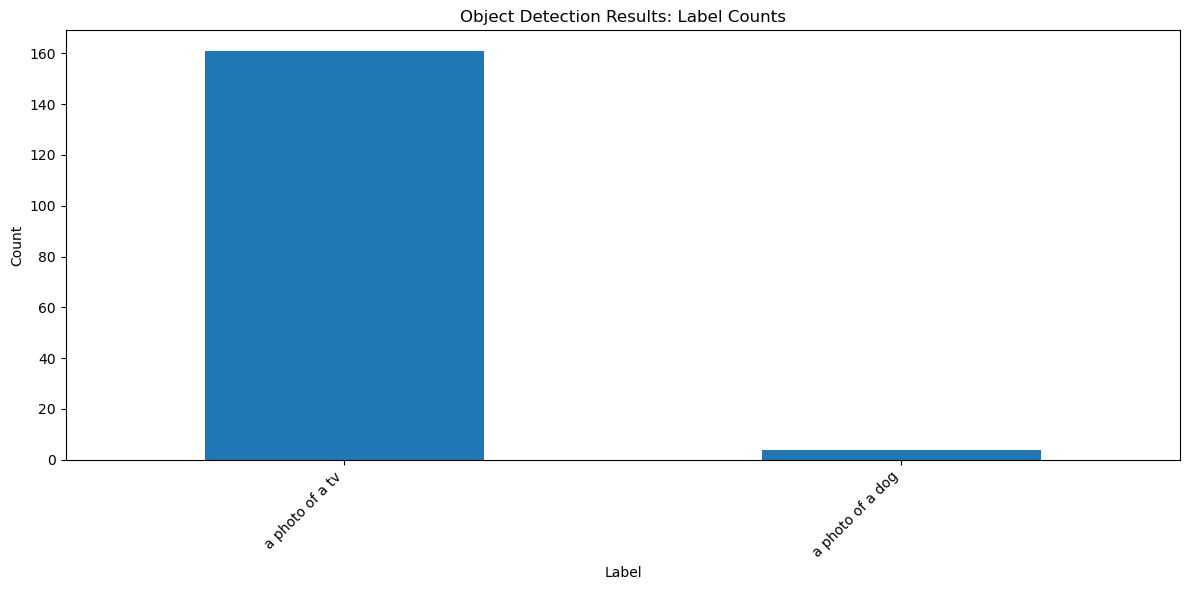

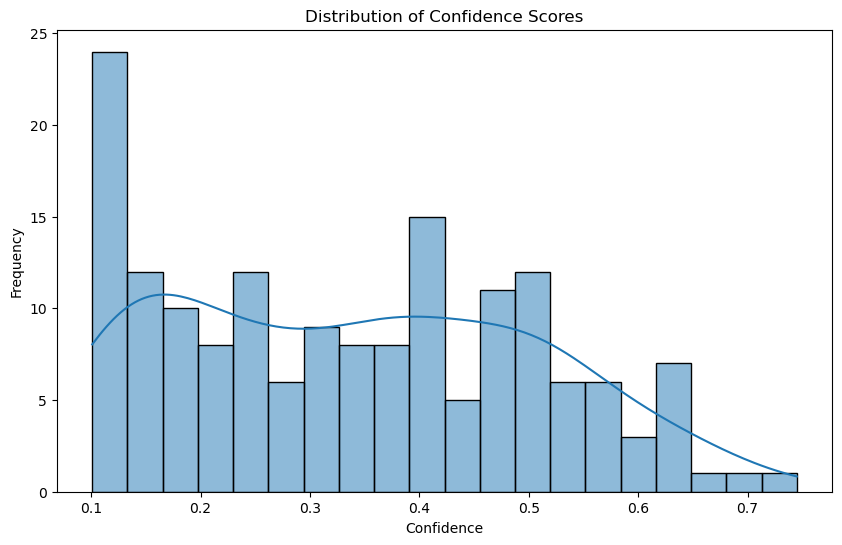


이미지별 탐지된 객체 수 (상위 10개):
filename
101.jpg    3
28.jpg     3
128.jpg    3
176.jpg    2
195.jpg    2
41.jpg     2
44.jpg     2
5.jpg      2
26.jpg     2
199.jpg    2
dtype: int64

상위 5개 라벨의 평균 신뢰도:
label
a photo of a tv     0.343609
a photo of a dog    0.139000
Name: confidence, dtype: float64


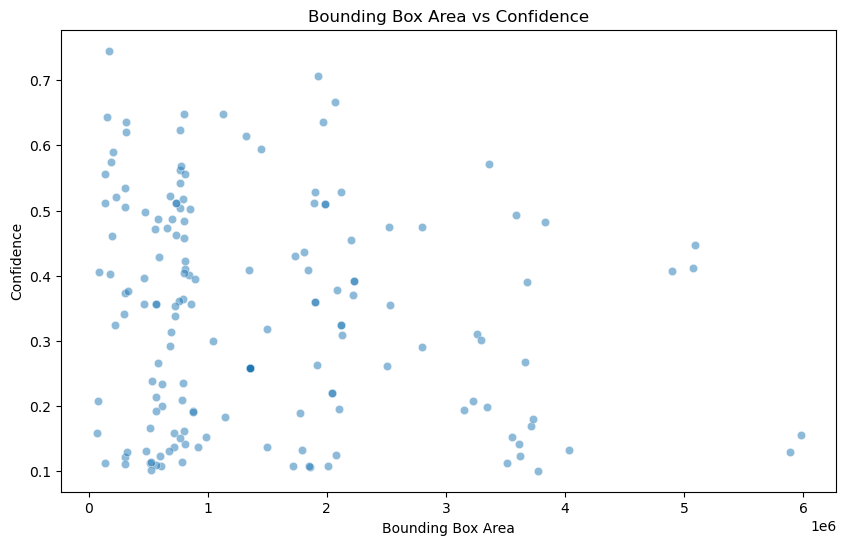

In [62]:
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 처리 및 DataFrame 생성
rows = []

for file_path in glob.glob(output_dirname + "/*.out"):
    # 파일 읽기
    filename = file_path.split("/")[-1].replace(".out", "")
    with open(file_path, 'r') as file:
        content = file.read()

    # JSON 파싱
    try:
        data = json.loads(content)
        for item in data:
            label, confidence, bbox = item
            x, y, width, height = bbox
            rows.append({
                'filename': filename,
                'label': label,
                'confidence': confidence,
                'x': x,
                'y': y,
                'width': width,
                'height': height
            })
    except json.JSONDecodeError:
        print(f"Error decoding JSON in file: {filename}")

df = pd.DataFrame(rows)

# 결과 출력
print("DataFrame 정보:")
print(df)

# 추가 정보 출력
print(f"\n총 탐지된 객체 수: {len(df)}")
print(f"고유한 이미지 파일 수: {df['filename'].nunique()}")
print(f"\n컬럼: {df.columns.tolist()}")

# 처음 5행 보기
print("\n처음 5행:")
print(df.head())


# 라벨별 개수
print("\n라벨별 개수:")
label_counts = df['label'].value_counts()
print(label_counts)

# 시각화: 라벨별 개수 막대 그래프
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Object Detection Results: Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 신뢰도 분포 히스토그램
plt.figure(figsize=(10, 6))
sns.histplot(df['confidence'], bins=20, kde=True)
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.show()

# 이미지별 탐지된 객체 수
objects_per_image = df.groupby('filename').size().sort_values(ascending=False)
print("\n이미지별 탐지된 객체 수 (상위 10개):")
print(objects_per_image.head(10))

# 상위 5개 라벨의 평균 신뢰도
top_5_labels = label_counts.head().index
avg_confidence = df[df['label'].isin(top_5_labels)].groupby('label')['confidence'].mean().sort_values(ascending=False)
print("\n상위 5개 라벨의 평균 신뢰도:")
print(avg_confidence)

# 시각화: 바운딩 박스 크기 vs 신뢰도 산점도
df['bbox_area'] = df['width'] * df['height']
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bbox_area', y='confidence', data=df, alpha=0.5)
plt.title('Bounding Box Area vs Confidence')
plt.xlabel('Bounding Box Area')
plt.ylabel('Confidence')
plt.show()